In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from PIL import Image

In [ ]:
# parameters
mm = 1e-3
um = mm*mm
nm = um*mm
wvl_R = 639 * nm  # Red
wvl_G = 525 * nm  # Green
wvl_B = 463 * nm  # Blue

# SLM size
w = 3840
h = 2160
pp = 3.6 * um # SLM pixel pitch
sizeXY = 0.03
sizeZ = 0.25

# Input image parameters
h_i = 1080
w_i = 1920
w_new = np.int(sizeXY / pp + 1)
h_new = np.int(w_new * (9 / 16) + 1)

# Numba function define


In [ ]:
import scipy

@njit
def k(wvl):
    return (2 * np.pi) / wvl

def fft(F):
    return scipy.fft.fftshift(scipy.fft.fft2(scipy.fft.fftshift(F)))

def ifft(F):
    return scipy.fft.fftshift(scipy.fft.ifft2(scipy.fft.fftshift(F)))

4688 8334


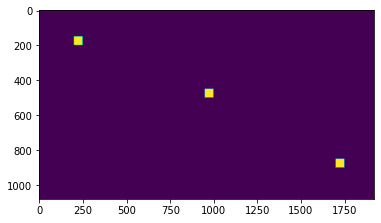

In [ ]:
# test image pattern making
test1 = np.zeros((h_i, w_i))  # 1920 x 1080 image
test1[150:200, 200:250] = 1
test1[850:900, 1700:1750] = 1
test1[450:500, 950:1000] = 1

print(h_new, w_new)
plt.imshow(test1)

# 1. RGB 파장에 따른 이미지 리사이징

RGB 파장에 따라 blue를 기준으로 이미지를 리사이징을 한 후 가운데로 배치한다.

In [ ]:
# wavelength ratio
BR = wvl_B / wvl_R
BG = wvl_B / wvl_G

def ratio(ratio):
    w_new = np.floor(ratio * w_i + 1)
    h_new = np.floor(ratio * h_i + 1)
    return int(w_new), int(h_new)

def resizeimg(image, ratios):
    w1, h1 = ratio(ratios)
    result = np.zeros((h_i, w_i))
    im = Image.fromarray(image)
    im = im.resize((w1, h1), Image.BILINEAR)
    ar = np.asarray(im)
    result[(h_i - h1)//2:(h_i + h1)//2, (w_i-w1)//2:(w_i+w1)//2] = ar
    return result

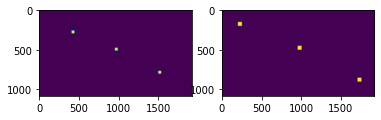

In [ ]:
red1 = resizeimg(test1, BR)
green1 = resizeimg(test1, BG)
blue1 = test1

plt.subplot(121)
plt.imshow(red1)
plt.subplot(122)
plt.imshow(blue1)

# 2. Sampling period에 따른 이미지 리사이징

SLM의 sampling period에 맞게 input 이미지를 리사이징하고 Zeropadding을 적용한다.

In [ ]:
print(h_new, ',', w_new)
Ws = sizeXY  # source plane width : 0.03 [m]
Wr = w * pp  # Reciever plane width : 0.0138 [m]

# zero padding number
def Nzp(zz, wvl):
    p = (wvl * zz) / np.sqrt(4 * pp * pp - wvl * wvl)
    return int((1 / pp) * (Wr / 2 - Ws / 2 + p) + 1)    

nzp = 4000

def sample_resizeimg(image):
    wtotal = nzp + w_new
    htotal = nzp + h_new
    result = np.zeros((htotal, wtotal))
    im = Image.fromarray(image)
    im = im.resize((w_new, h_new), Image.BILINEAR)
    ar = np.asarray(im)
    result[(htotal - h_new)//2:(htotal + h_new)//2, (wtotal-w_new)//2:(wtotal+w_new)//2] = ar
    return result

4688 , 8334


In [ ]:
red2 = sample_resizeimg(red1)
green2 = sample_resizeimg(green1)
blue2 = sample_resizeimg(blue1)
print(red2.shape)

(8688, 12334)


# 3. Transfer function generation
Angular spectrum method의 transfer function을 만듬

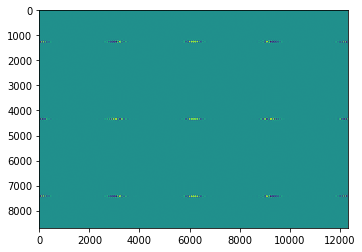

In [ ]:
# new size
w1 = nzp + w_new
h1 = nzp + h_new

@njit
def asm_kernel(wvl):
    # transfer function (w x w 로 만들어 보기 -> 이후 crop)
    Hi = np.zeros((h1, w1))
    Hr = np.zeros((h1, w1))
    deltak = 1 / w1 / pp  # M 개의 sample, sampling perieod = pp
    zz = 1  # propagation distance
    for i in range(w1):
        for j in range(h1):
            fx = (i - w1/2) * deltak
            fy = -(j - h1/2) * deltak
            re = np.cos(-2 * np.pi * zz * np.sqrt((1/wvl)**2 - fx * fx - fy * fy))
            im = np.sin(-2 * np.pi * zz * np.sqrt((1/wvl)**2 - fx * fx - fy * fy))
            Hr[j, i] = re
            Hi[j, i] = im
    return Hr + 1j*Hi

plt.imshow(np.real(asm_kernel(wvl_R)))

In [ ]:
%time a = np.imag(asm_kernel(wvl_R))

CPU times: user 9.17 s, sys: 2.38 s, total: 11.5 s
Wall time: 11.5 s


# 4. ASM 수행
fft를 사용한 홀로그램을 생성한다.

In [ ]:
%%time
Red1 = fft(red2)  # input image fft
Red2 = Red1 * asm_kernel(wvl_R)
result = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(Red2)))

CPU times: user 50.8 s, sys: 3.42 s, total: 54.2 s
Wall time: 54.2 s


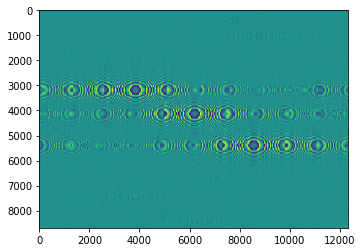

In [ ]:
plt.imshow(np.angle(result))

# 5. Reference Light와 간섭


In [ ]:
ch = np.zeros((h, w))
result = np.angle(result)
ch = result[(h1 - h)//2:(h1+h)//2, (w1-w)//2:(w1+w)//2]

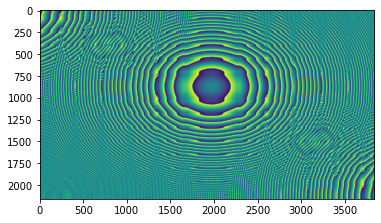

In [ ]:
plt.imshow(ch)